<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_17/5_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация DQN

В этом уроке мы разберем на практике обучение DQN (Deep Q Network) для задачи Frozen Lake.

### Используем TensorFlow 2.0

На момент подготовки этих материалов в Google Colab по умолчанию используется версия TensorFlow 1.X

Переключаемся на версию 2.0 (работает только в Colab)

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Загрузка библиотек

Для обучения нейросети будем использовать TensorFlow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

import tensorflow as tf

### Создание игровой среды
Создадим симулятор Frozen Lake.

In [3]:
env = gym.make('FrozenLake-v0', is_slippery=False)

NUM_STATES = env.observation_space.n
NUM_ACTIONS = env.action_space.n

print('States: {}'.format(NUM_STATES))
print('Actions: {}'.format(NUM_ACTIONS))

States: 16
Actions: 4


### Параметры обучения

* `lr` - скорость обучения (в теории это был параметр `alpha`)
* `gamma` - параметр дисконтирования
* `NUM_EPISODES` - сколько всего эпизодов игры будем осуществлять
* `MAX_STEPS` - максимальное количесвто шагов в рамках одного эпизода. Эпизод может закончиться и раньше. Это ограничение нужно, если агент зашёл в какой-то тупик и там застрял. Или для бесконечных игр/симуляций.

Кроме того, будем смотреть на награду, усреднённую в некотором временнОм окне (окно по эпизодам).

* `REWARD_AVERAGE_WINDOW` - размер этого окна.

In [4]:
lr = 0.1 # learning rate
gamma = 0.99 # параметр дисконтирования

NUM_EPISODES = 1000 # число эпизодов для обучения
MAX_STEPS = 100 # максимальное число шагов в эпизоде

REWARD_AVERAGE_WINDOW = 20 # окно для усреднения наград по эпизодам

### Создание модели

Создадим простую модель для аппроксимации оптимальной Q-функции. Формально это будет нейронная сеть на TensorFlow. Однако, по факту, мы будем использовать лишь один Embedding слой. Это обучаемый слой, который по некоторому целочисленному входу выдаёт некоторый вектор. Именно это нам и нужно для отображения состояния `s` в вектор `Q(s, :)` для различных действий.

Интересным фактом является то, что так как Embedding слой это по сути матрица, а прямое распространиене для него -- это выбор `s`-той строчки в этой матрице, такая модель эквивалентная обычной Q-таблице. Такое сработает лишь потому, что у нас очень простая задача (Frozen Lake). Для более сложных задач надо использовать более сложные нейросети.

Кроме самой модели создадим функцию для инференса `evalQ`, которая будет вычислять вектор `Q(s, :)` по входному состоянию `s`

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_STATES, NUM_ACTIONS, tf.initializers.RandomUniform(0, 1)),
])

def evalQ(s):
    inp = np.array([[s]], dtype=np.int32)
    return model(inp).numpy()[0][0]

### Подготовка к обучению

В качестве функции потерь будем использовать квадрат нормы разницы между целевым и предсказанным вектором Q(s, :), как это обычно делается в задачах регрессии (ведь нам нужно притянуть друг к другу эти два вектора). Зададим это функцией `loss()`

В качестве оптимизатора для нейросети будем использовать SGD.

In [7]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model.compile(loss=loss, optimizer=optimizer)

### Обучение DQN

Обучение DQN во многом похоже на табличный Q-Learning. Рассмотрим подробнее лишь те части, котороые отличаются.

Чтобы получить значения Q-функции для текущего состояния `s` и всех действий, воспользуемся функцией `evalQ`: 

`Q_s = evalQ(s)`

Во время обучения будем использовать eps-greedy подход для выбора действия (в зависимости от параметра `eps` выбирать случайное действие или по текущей политике).

Самое интересное -- как сделать обновление Q-функции. Для начала, надо разобраться, как получить целевой вектор Q-target. Вспомним, что в Q-Learning мы должны обновить только значение `Q(s, a)` (через уравнение Беллмана). Но так как нейросеть предсказывает веткор для всех возможных действий (`Q(s, :)`), сделать нужно следующим образом.

 Пусть целевой вектор для `Q(s, :)` будет равен исходным (предсказанным нейросетью) значениям для всех действий, кроме действия `a`. То есть скопируем в `Q_target` текущий предсказанный `Q_s` и заменим в нём лишь `Q_target[a]` на та, что дает нам Беллман. И теперь наша задача "обучить" нейросеть на этот целевой вектор, то есть заставить её изменить свои веса так, чтобы только значение для действия `a` изменилось, а остальные значения `Q(s, :)` по возможности не изменялись. Делаем это через минимизацию ошибки между этими векторами.

А чтобы сделать один шаг минимизации ошибки, нам надо сделать один шаг градиентного спуска (или в общем случае один шаг обучения модели). Сделать это можно с помощью функции `model.train_on_batch(...)`, которая делает шаг обучения на данном батче. На входе у неё батч входов и батч правильных ответов. У нас будет батч из одного элемента.

В остальном всё то же самое, как было в Q-Learning.

И еще дополнительно накапливаем список "усредненных в окне наград" -- `totalRewardAverageList`

In [8]:
pathLenList = [] # длины траекторий по эпизодам
totalRewardList = [] # суммарные награды по эпизодам
totalRewardAverageList = [] # суммарные награды по эпизодам (среднее по окну)

for i in range(NUM_EPISODES):

    eps = 1.0 - i / NUM_EPISODES

    s = env.reset()

    totalReward = 0
    step = 0

    while step < MAX_STEPS:
        step += 1

        Q_s = evalQ(s)
        
        if np.random.rand() < eps:
            # Выбор случайного действия
            a = env.action_space.sample()
        else:
            # Выбор действия по текущей политике
            a = np.argmax(Q_s)
        
        # Сделать шаг
        s1, r, done, _ = env.step(a)

        Q_s1 = evalQ(s1)
        
        # Новое (целевое) значение Q-функции
        Q_target = Q_s
        if done:
            Q_target[a] = r
        else:
            Q_target[a] = r + gamma * np.max(Q_s1)
              
        # Обновление Q-функции
        inp = np.array([[s]], dtype=np.int32)
        model.train_on_batch(inp, Q_target[None, None, ...])
        
        totalReward += r
        s = s1
        
        # Если конец эпизода
        if done:
            break
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)
    
    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))

Episode 100: average total reward = 0.05
Episode 200: average total reward = 0.0
Episode 300: average total reward = 0.3
Episode 400: average total reward = 0.3
Episode 500: average total reward = 0.45
Episode 600: average total reward = 0.55
Episode 700: average total reward = 0.6
Episode 800: average total reward = 0.9
Episode 900: average total reward = 1.0


Посмотрим на историю длин траекторий.

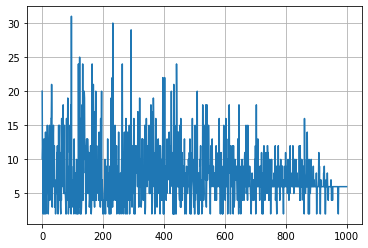

In [9]:
plt.plot(pathLenList)
plt.grid()

Посмотрим на среднюю суммарную награду. Видно, что это значение со временем стремится к единице (то есть все траектории в окне начинают доходить до конца). Во многом такой вид графика связан с eps-greedy подходом и с тем, что `eps` падает с номером эпохи.

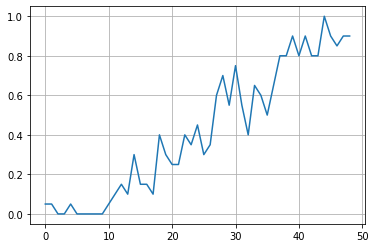

In [10]:
plt.plot(totalRewardAverageList)
plt.grid()

### Запуск симуляции

Запустим симуляцию для Frozen Lake так же, как мы делали до этого. 

В качестве политики будем использовать нашу обученную DQN:

`np.argmax(evalQ(s))`

In [11]:
totalReward = 0
s = env.reset()

for _ in range(100):
    env.render()
    a = np.argmax(evalQ(s)) # выбираем оптимальное действие
    s, r, done, _ = env.step(a)
    totalReward += r
    if done:
        env.render()        
        break

env.close()
print('Total reward = {}'.format(totalReward))


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Total reward = 1.0


**[Задание 1]** Добавьте в DQN полносвязных слоёв (сделайте сеть глубже) и переобучите агента. Обратите внимание на инициализацию параметров (весов) слоёв. При некоторых начальных значениях модель может не сходиться. Используйте парметр `kernel_initializer` для `tf.keras.layers.Dense`

In [ ]:
model_new = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_STATES, NUM_ACTIONS, tf.initializers.RandomUniform(0, 1)),
])